In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE


In [ ]:
# Load dataset
data = pd.read_csv('flood_risk_dataset_india.csv')

# Preview the data
print(data.head())
print(data.info())


    Latitude  Longitude  Rainfall (mm)  Temperature (°C)  Humidity (%)  \
0  18.861663  78.835584     218.999493         34.144337     43.912963   
1  35.570715  77.654451      55.353599         28.778774     27.585422   
2  29.227824  73.108463     103.991908         43.934956     30.108738   
3  25.361096  85.610733     198.984191         21.569354     34.453690   
4  12.524541  81.822101     144.626803         32.635692     36.292267   

   River Discharge (m³/s)  Water Level (m)  Elevation (m)    Land Cover  \
0             4236.182888         7.415552     377.465433    Water Body   
1             2472.585219         8.811019    7330.608875        Forest   
2              977.328053         4.631799    2205.873488  Agricultural   
3             3683.208933         2.891787    2512.277800        Desert   
4             2093.390678         3.188466    2001.818223  Agricultural   

  Soil Type  Population Density  Infrastructure  Historical Floods  \
0      Clay         7276.742184   

In [ ]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(data, columns=["Land Cover", "Soil Type"], drop_first=True)

# Define features (X) and target (y)
X = df_encoded.drop(columns=["Flood Occurred"])
y = df_encoded["Flood Occurred"]


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Undersample the majority class because of data imbalances
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Check the class distribution after undersampling
print(y_resampled.value_counts())


Flood Occurred
0    4943
1    4943
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_resampled = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X.columns)


In [ ]:
# Perform Recursive Feature Elimination (RFE) to select top 10 features
rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=10)
X_selected = rfe.fit_transform(X_resampled, y_resampled)

# Get the selected feature names
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Re-split the dataset using the selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.3, random_state=42)


Selected Features: Index(['Longitude', 'Temperature (°C)', 'Humidity (%)', 'Water Level (m)',
       'Population Density', 'Historical Floods', 'Land Cover_Forest',
       'Land Cover_Water Body', 'Soil Type_Loam', 'Soil Type_Silt'],
      dtype='object')


In [ ]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Logistic Regression ROC-AUC Score:", roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))


Logistic Regression Accuracy: 0.5040458530006743
Logistic Regression ROC-AUC Score: 0.5108156891957711


In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC-AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


Random Forest Accuracy: 0.4858395144976399
Random Forest ROC-AUC Score: 0.48946399750055597


In [ ]:
from xgboost import XGBClassifier

# Train XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost ROC-AUC Score:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1]))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:43:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.5020229265003372
XGBoost ROC-AUC Score: 0.4970237242534753


In [ ]:
# Adjust the threshold for Random Forest
rf_probs = rf.predict_proba(X_test)[:, 1]
threshold = 0.4  # Adjust based on evaluation needs
y_pred_adjusted = (rf_probs > threshold).astype(int)

# Evaluate adjusted predictions
print("Adjusted Accuracy:", accuracy_score(y_test, y_pred_adjusted))
print("Adjusted ROC-AUC Score:", roc_auc_score(y_test, rf_probs))


Adjusted Accuracy: 0.49224544841537426
Adjusted ROC-AUC Score: 0.48946399750055597


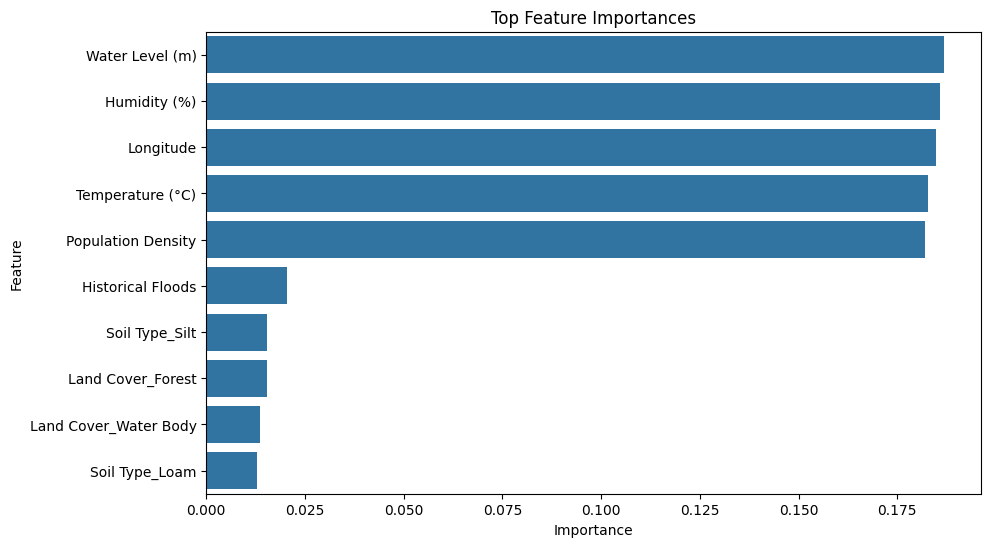

In [ ]:
# Feature importance from Random Forest
importances = pd.DataFrame({'Feature': selected_features, 'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title("Top Feature Importances")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['lbfgs', 'liblinear']  # Solvers compatible with logistic regression
}

# Initialize GridSearchCV
grid_log_reg = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='roc_auc',  # Optimize for ROC-AUC
    verbose=1
)

# Perform grid search
grid_log_reg.fit(X_train, y_train)

# Retrieve the best parameters and best model
best_params = grid_log_reg.best_params_
best_log_reg = grid_log_reg.best_estimator_

print("Best Parameters:", best_params)

# Evaluate the tuned logistic regression model
y_pred_best_log_reg = best_log_reg.predict(X_test)
print("Tuned Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_best_log_reg))
print("Tuned Logistic Regression ROC-AUC Score:", roc_auc_score(y_test, best_log_reg.predict_proba(X_test)[:, 1]))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'C': 0.1, 'solver': 'liblinear'}
Tuned Logistic Regression Accuracy: 0.5026972353337829
Tuned Logistic Regression ROC-AUC Score: 0.510819327396699


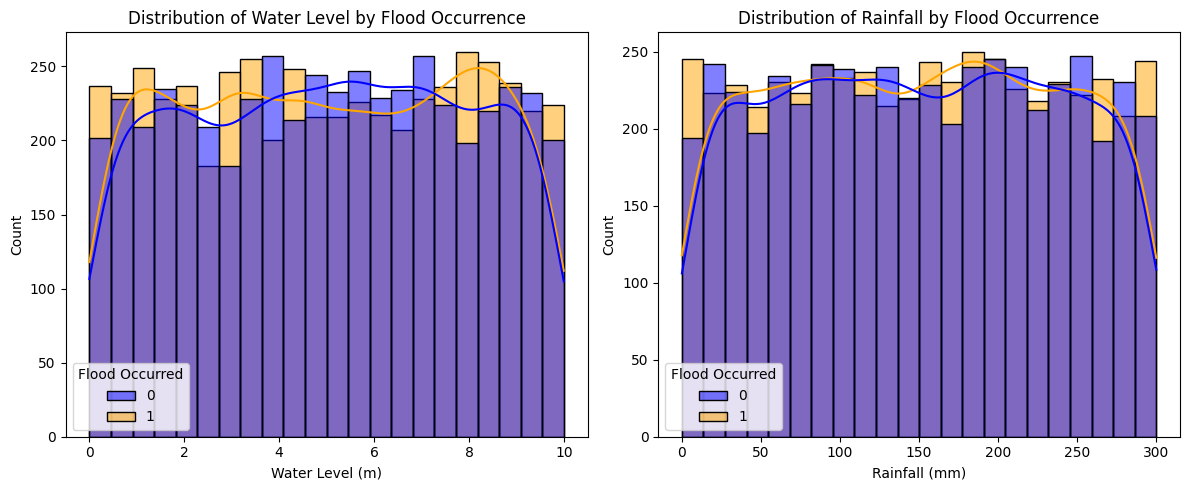

In [ ]:
# Visualize distributions of selected features (e.g., 'Water Level (m)' and 'Rainfall')
import seaborn as sns

plt.figure(figsize=(12, 5))

# Distribution of Water Level
plt.subplot(1, 2, 1)
sns.histplot(data=df_encoded, x='Water Level (m)', hue='Flood Occurred', kde=True, palette=['blue', 'orange'])
plt.title('Distribution of Water Level by Flood Occurrence')

# Distribution of Rainfall
plt.subplot(1, 2, 2)
sns.histplot(data=df_encoded, x='Rainfall (mm)', hue='Flood Occurred', kde=True, palette=['blue', 'orange'])
plt.title('Distribution of Rainfall by Flood Occurrence')

plt.tight_layout()
plt.show()


<ipython-input-43-bde3ae0ebedf>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = data.groupby(['Rainfall_bin', 'Water_Level_bin'])['Flood Occurred'].mean().unstack()


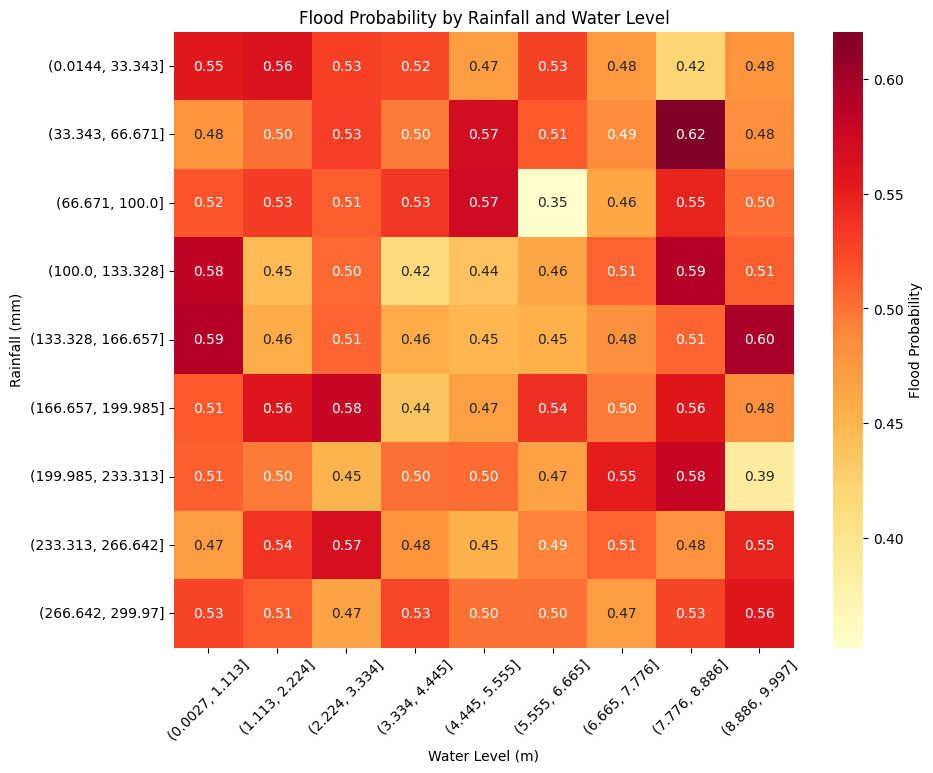

In [ ]:
# Define bin edges for Rainfall and Water Level
rainfall_bins = np.linspace(data['Rainfall (mm)'].min(), data['Rainfall (mm)'].max(), 10)
water_level_bins = np.linspace(data['Water Level (m)'].min(), data['Water Level (m)'].max(), 10)

# Bin data
data['Rainfall_bin'] = pd.cut(data['Rainfall (mm)'], bins=rainfall_bins)
data['Water_Level_bin'] = pd.cut(data['Water Level (m)'], bins=water_level_bins)

# Calculate flood probability per bin
heatmap_data = data.groupby(['Rainfall_bin', 'Water_Level_bin'])['Flood Occurred'].mean().unstack()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt=".2f", cbar_kws={'label': 'Flood Probability'})
plt.title("Flood Probability by Rainfall and Water Level")
plt.xlabel("Water Level (m)")
plt.ylabel("Rainfall (mm)")
plt.xticks(rotation=45)
plt.show()

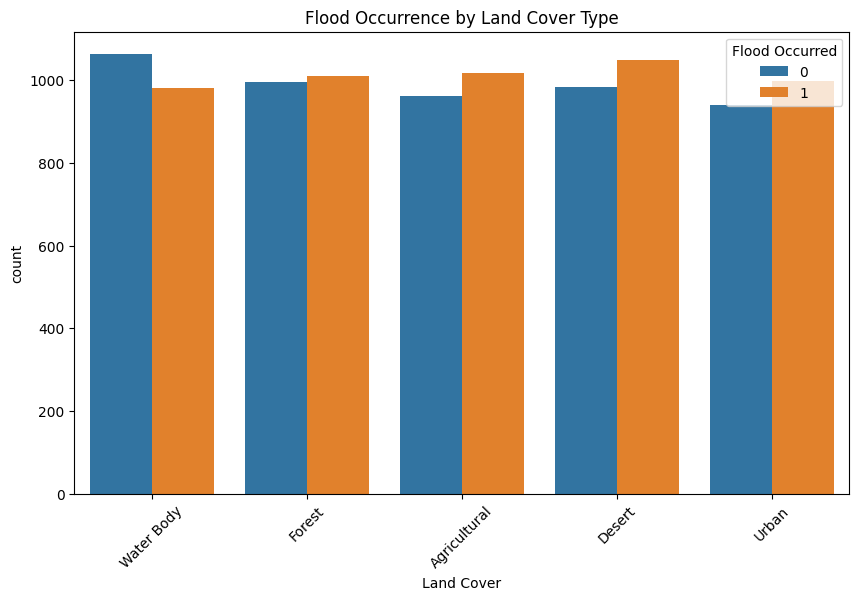

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from IPython.display import display


# 3. Flood Occurrence by Land Cover Type
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Land Cover', hue='Flood Occurred')
plt.title('Flood Occurrence by Land Cover Type')
plt.xticks(rotation=45)
plt.show()




In [ ]:
# Geospatial Visualization of Flood Occurrences
# Initialize the map centered on the average latitude and longitude
m = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()], zoom_start=5)

# Use MarkerCluster for a cleaner look if there are many points
marker_cluster = MarkerCluster().add_to(m)

# Add points for each row in the dataset
for _, row in data.iterrows():
    color = 'red' if row['Flood Occurred'] == 1 else 'blue'
    folium.CircleMarker(
        [row['Latitude'], row['Longitude']],
        radius=2,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(marker_cluster)

# Display the map in the notebook
display(m)
